In [75]:
# Import libraries
import sys
sys.path.append('..\\helpers')

import cv2
import random
import os
import matplotlib.pyplot as plt
import numpy as np
from loguru import logger
import pandas as pd
import seaborn as sns
from PIL import Image, ImageDraw
from functools import reduce

import math
from scipy import ndimage



# From helpers directory
from preprocessing import Preprocessor
#from morphological_sifter import MorphologicalSifter
import display

preprocessor = Preprocessor()
#mms = MorphologicalSifter()

In [76]:
# Define dataset folder path
dataset_folder_paths = [(x[0].split("\\")[-1], x[0]) for x in os.walk("..\\dataset")][1:]

# Show the paths of the folder
dataset_folder_paths

[('groundtruth', '..\\dataset\\groundtruth'),
 ('images', '..\\dataset\\images'),
 ('masks', '..\\dataset\\masks'),
 ('overlay', '..\\dataset\\overlay')]

In [77]:
# Read image data and make dataframe
positive_labelled_images = []
negative_labelled_images = []

dataset = []
dataset_path = '..\\dataset'

labels = ["positives", "negatives"]

for idx, object in enumerate(labels):
        with open(f'..\\dataset\\{str(object)}.txt') as f:
            lines = f.read().splitlines()
            
            for line in lines:
                if line != "":
                    new_path = os.path.join(dataset_path, 'images', line)
                    
                    dataset.append((str(object), line))
                    positive_labelled_images.append(new_path) if str(object) == 'positives' else negative_labelled_images.append(new_path)

dataset_df = pd.DataFrame(dataset, columns=['class', 'filename'])

# Show the dataframe with lebel (positive and negative)
dataset_df 

,class,filename
0,positives,20586908_6c613a14b80a8591_MG_R_CC_ANON.tif
1,positives,20586934_6c613a14b80a8591_MG_L_CC_ANON.tif
2,positives,20586960_6c613a14b80a8591_MG_R_ML_ANON.tif
3,positives,20586986_6c613a14b80a8591_MG_L_ML_ANON.tif
4,positives,20587612_f4b2d377f43ba0bd_MG_R_CC_ANON.tif
...,...,...
405,negatives,53587572_11e6732579acf692_MG_L_ML_ANON.tif
406,negatives,53587599_11e6732579acf692_MG_L_CC_ANON.tif
407,negatives,53587690_5fb370d4c1c71974_MG_L_ML_ANON.tif
408,negatives,53587717_5fb370d4c1c71974_MG_R_ML_ANON.tif


In [78]:
# Summary of the dataset
dataset_df.describe()

,class,filename
count,410,410
unique,2,410
top,negatives,20586908_6c613a14b80a8591_MG_R_CC_ANON.tif
freq,303,1


In [79]:
# Duplicate file checking
len(dataset_df["filename"].unique())

410

<AxesSubplot: >

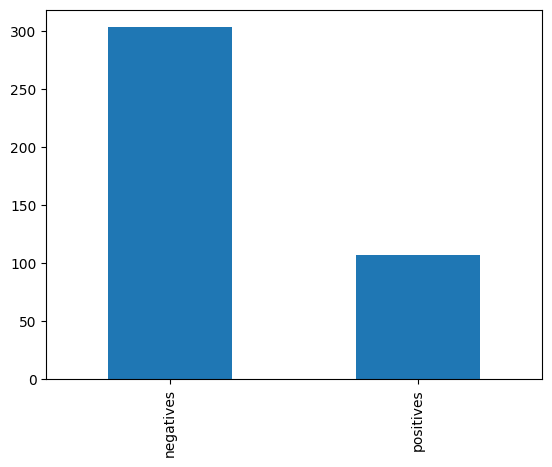

In [80]:
# Visualizing the dataset
dataset_df["class"].value_counts().plot(kind='bar')

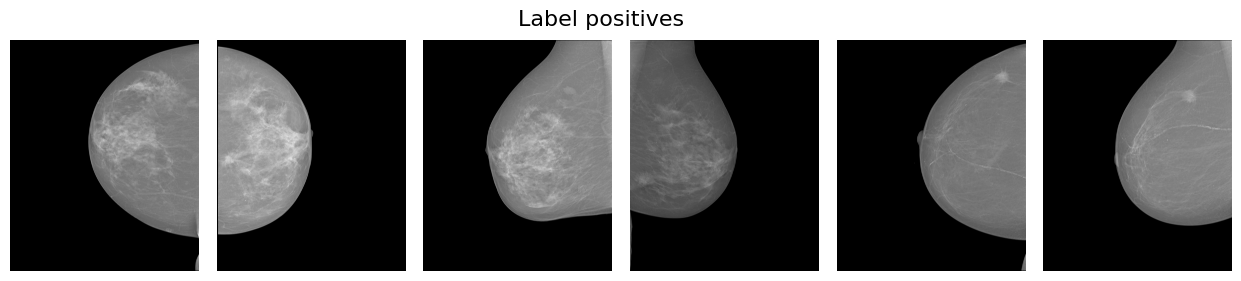

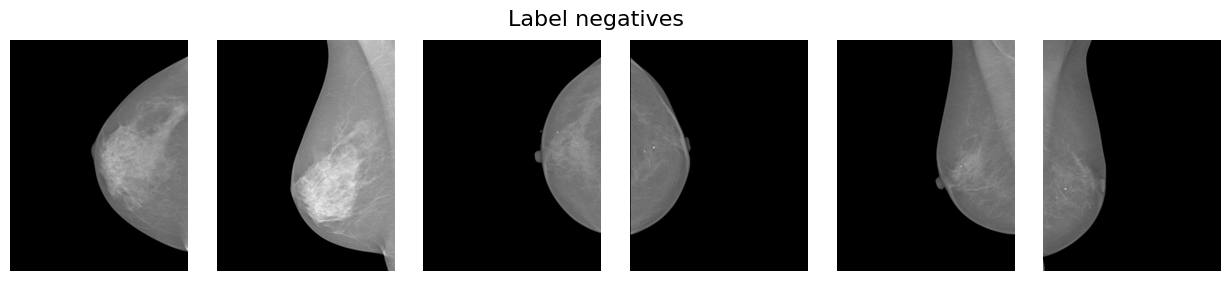

In [81]:
# Plotting images from the dataset
for idx, lbl in enumerate(labels):
    nrows, ncols = 1, 6
    fig, ax = plt.subplots(nrows, ncols, figsize=(16, 3))
    plt.subplots_adjust(wspace=0, hspace=1)

    for idx, fname in enumerate(dataset_df.loc[dataset_df['class'] == lbl]['filename'][:ncols]):
        img = Image.open(os.path.join(dataset_path, 'images',fname))
        plt.subplot(nrows, ncols, idx+1)
        plt.imshow(np.array(img), cmap='gray')
        fig.suptitle(f'Label {lbl}', fontsize=16)
        plt.axis('off')

In [82]:
# Reading single image 
random_idx = random.randint(0,120)

img_name = os.listdir(os.path.join(dataset_folder_paths[0][1]))[random_idx]
img_path = os.path.join(dataset_folder_paths[1][1], img_name)

# Plotting single original image
img = cv2.imread(img_path)
#plt.imshow(np.array(img), cmap='gray')
print(img_name)
img.shape

53582683_465aa5ec1b59efc6_MG_L_CC_ANON.tif


(3328, 2560, 3)

Resized Image Shape: (1331, 1024, 3)
Gray Image Shape: (1331, 1024)


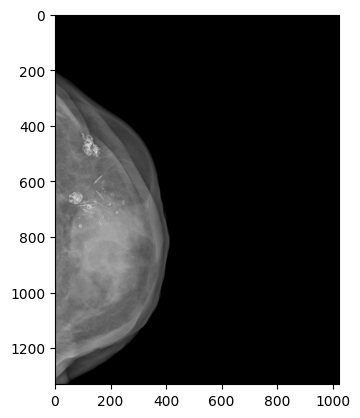

In [83]:
# 1. resizing image with a factor of 4 using INTER_CUBIC (bi-cubic) interpolation
scale_factor = 0.4  #reduces pixel size 
img_resized = cv2.resize(img.copy(), None, fx=scale_factor, fy=scale_factor, interpolation=cv2.INTER_CUBIC)
print(f"Resized Image Shape: {img_resized.shape}")
plt.imshow(np.array(img_resized), cmap='gray')

img_gray = cv2.cvtColor(img_resized.copy(), cv2.COLOR_BGR2GRAY)
print(f"Gray Image Shape: {img_gray.shape}")
plt.imshow(np.array(img_gray), cmap='gray')

Thresholded Mask Shape: (1331, 1024)


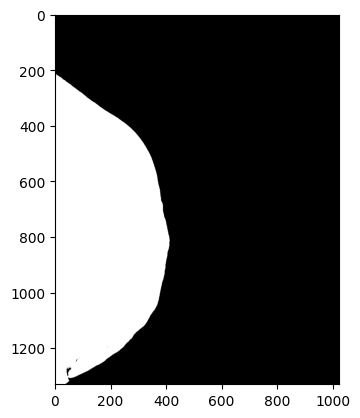

In [84]:

# 2. Pre-segmenting using thresholding technique and cropping redundant background
# https://stackoverflow.com/questions/63575738/remove-letter-artifacts-from-mammography-image
# The first argument is the source image, which should be a grayscale image. The second argument is 
# the threshold value which is used to classify the pixel values. The third argument is the maximum value
# which is assigned to pixel values exceeding the threshold. 
thresholding_mask = cv2.threshold(img_gray.copy(), 30, 255, cv2.THRESH_BINARY)[1] #threshoding pixel intensities
print(f"Thresholded Mask Shape: {thresholding_mask.shape}")
plt.imshow(np.array(thresholding_mask), cmap='gray')

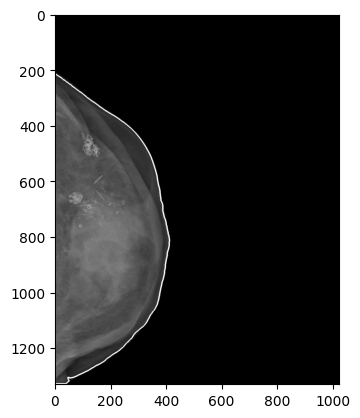

In [85]:
# To remove redundant image, lets find the contours from the mask we generated
contours, _ = cv2.findContours(thresholding_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
largest_contour = max(contours, key=cv2.contourArea)
x, y, w, h = cv2.boundingRect(largest_contour)
contour_image = cv2.drawContours(img_gray.copy(), [largest_contour], -1, (255, 255, 255), 3)
cropped_image = img_gray.copy()[y:y+h, x:x+w]
plt.imshow(np.array(contour_image), cmap='gray') #contour of the breast shape

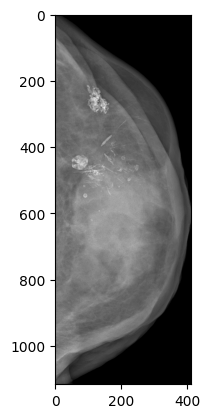

In [86]:
# 3. Rescale (Normalize) the image to 16-bit unsigned integer (0-65535)
# Note, clahe expects 8-bit (0-255) not 16 ..
rescaled_16_bit_img = cv2.normalize(cropped_image.copy(), None, 0, 65535, cv2.NORM_MINMAX, dtype=cv2.CV_16U)

# convert to 8-bit image
rescaled_8_bit_img = cv2.convertScaleAbs(rescaled_16_bit_img, alpha=(255.0/65535.0))

plt.imshow(np.array(rescaled_8_bit_img), cmap='gray') #normalized image 8 bit

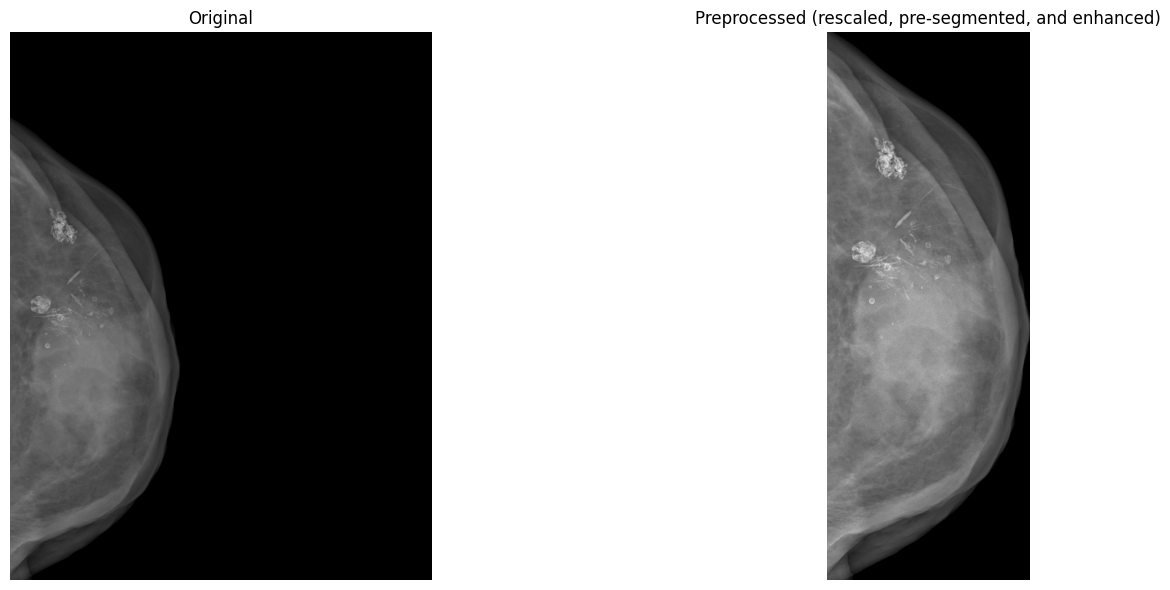

In [87]:
# 4. Applying CLAHE
clahe = cv2.createCLAHE(clipLimit=0.01, tileGridSize=(4,4))
clahe_img = clahe.apply(rescaled_8_bit_img.copy()) 

imgs = {
    "Original": img, 
#     "Threshold Mask": thresholding_mask, 
#     "Contour on Gray Image": contour_image, 
#     "Cropped Image (Grayscale Version)": cropped_image, 
#     "Rescaled 16-bit":rescaled_img,
    "Preprocessed (rescaled, pre-segmented, and enhanced)": clahe_img
}

display.plot_figures(imgs, 1, 2)

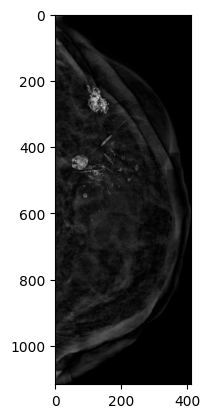

In [88]:
# define the kernel for the top-hat operation
kernel_size = 50
kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (kernel_size, kernel_size))

# perform top-hat morphological transformation
tophat_img = cv2.morphologyEx(clahe_img, cv2.MORPH_TOPHAT, kernel)

# perform top-hat morphological transformation
tophat_img = cv2.morphologyEx(tophat_img, cv2.MORPH_TOPHAT, kernel)

#ploting tophat morphological image
plt.imshow(np.array(tophat_img), cmap='gray')

In [89]:

# All of the above is now implemented in a separate class and can be applied using the following line of code
preprocessor.fit(dataset_path=dataset_folder_paths[1][1], 
                 process_n=1, 
                 plot=True, 
                 export_processed=False)


AttributeError: module 'logger' has no attribute 'info'